In [1]:
import pandas as pd
from sklearn.cluster import DBSCAN
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
#importing data 
frame = pd.read_csv('../data/02_intermediate/cleaned_data.csv')
frame

,country,city,lat,lon,user_id
0,Polska,Kraków,50.046910,19.997064,1022388809810563072
1,Polska,Polska,52.097718,19.025816,1022388809810563072
2,Czad,Czad,15.613414,19.015617,1022388809810563072
3,Czad,Czad,13.021107,14.580308,1022388809810563072
4,Polska,Poznań,52.408266,16.933520,1022388809810563072
...,...,...,...,...,...
9887,Polska,Warszawa,52.231924,21.006726,111313124
9888,USA,Warsaw,37.958746,-76.758021,111313124
9889,Polska,Warszawa,52.233717,21.071411,111313124
9890,Polska,Warszawa,52.233717,21.071411,111313124


In [3]:
answer_frame = pd.read_csv('../data/02_intermediate/users_cleaned.csv')
answer_frame = answer_frame[["id","lat","lon" ]]
answer_frame

,id,lat,lon
0,256206247,52.233717,21.071411
1,1502354401889075202,52.233717,21.071411
2,1107329450969042945,52.233717,21.071411
3,1325917892597190656,52.233717,21.071411
4,564532437,52.233717,21.071411
...,...,...,...
410,1244159140102049795,52.881849,18.792525
411,932845070,52.665564,19.096130
412,1090917087961407490,50.091734,18.219677
413,774154579889958913,52.535974,17.595889


In [4]:
def remove_twitts_from_users_that_have_no_answer(twitts, answer):
        final = pd.DataFrame()
        for idx in answer["id"].unique().tolist():
            tmp = twitts[twitts["user_id"] == idx]
            final = pd.concat([final, tmp])
        return final

In [5]:
frame = remove_twitts_from_users_that_have_no_answer(frame, answer_frame)

In [6]:
frame

,country,city,lat,lon,user_id
8477,Węgry,Węgry,47.181759,19.506094,256206247
4689,Belgia,Belgia,50.640281,4.666715,1107329450969042945
4690,Tunezja,العرب,37.155187,9.548342,1107329450969042945
4691,Tunezja,العرب,36.116681,9.439643,1107329450969042945
4692,Rosja,Rosja,64.686314,97.745306,1107329450969042945
...,...,...,...,...,...
8791,Japonia,Usa,33.532005,131.349674,932845070
8792,Polska,Polska,52.097718,19.025816,932845070
8793,Polska,Polska,52.097718,19.025816,932845070
8794,Polska,Polska,52.097718,19.025816,932845070


In [7]:
# remove city Polska, Niemcy
frame = frame[(frame['city'] != "Polska") & (frame['city'] != "Niemcy") ]
len(frame)

4265

In [8]:
# remove those not from poland
frame = frame[(frame['country'] == "Polska")]

In [9]:
# remove those with small number of rows smaller than 5
counts = frame.groupby(['user_id'])['user_id'].count()
counts = counts[counts >= 1]
proper_users = counts.keys().to_list()
len(proper_users)

127

In [12]:
# spliting frame for every user
def create_dataframe_for_every_user(list_of_users, locations):
    users_frames_list = []
    for idx in list_of_users:
        users_frames_list.append(locations[locations['user_id'] == idx].copy())
    return users_frames_list

In [13]:
# Define a function to compute the Haversine distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of Earth in kilometers
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Define a distance metric based on the Haversine function
def haversine_distance(x1, x2):
    lat1, lon1 = x1[0], x1[1]
    lat2, lon2 = x2[0], x2[1]
    return haversine(lat1, lon1, lat2, lon2)

In [152]:
def dbscan(input_frame):
    input_frame.drop(labels=['country','city','user_id'], axis=1, inplace=True)
    scaller = MinMaxScaler(feature_range= (-1,1))
    scaller.fit(input_frame)        
    dbscan = DBSCAN(eps=1, min_samples=1, metric=haversine_distance)
    dbscan.fit(scaller.transform(input_frame))
    
    return dbscan
    

In [153]:
def compute_db_scann_for_all(users_frames_list):
    result = pd.DataFrame({"id":[],"lat":[],"lon":[]})
    for tmp_frame in users_frames_list:
        
        input_frame = tmp_frame.copy()
        db = dbscan(input_frame)
        input_frame['cluster'] = db.labels_
        if (len(set(db.labels_)) == 1):
            prediction = np.array([input_frame["lat"].values.mean(),input_frame["lon"].values.mean()])
        else:
            input_frame = input_frame[input_frame['cluster'] != -1]
            biggest_cluster = pd.Series.idxmax(input_frame.groupby(['cluster'])['cluster'].count())
            prediction = np.array([input_frame[input_frame['cluster'] == biggest_cluster]["lat"].values.mean(),input_frame[input_frame['cluster'] == biggest_cluster]["lon"].values.mean()])
        result.loc[len(result)] = [str(tmp_frame.iloc[0]["user_id"]),prediction[0],prediction[1] ]
    return result

In [154]:
result = compute_db_scann_for_all(users_frames_list)
result["id"] = result["id"].astype("int64")

with_ans = result.merge(answer_frame[["id","lat","lon"]], how = "left" , on="id" )

In [155]:
pred = with_ans[["lat_x","lon_x"]].values
ans = with_ans[["lat_y","lon_y"]].values
error = []
for i in range(0, len(pred)):
    error.append(haversine_distance(pred[i],ans[i]))
np.array(error).mean()

141.59711720736226

In [ ]:
reslut_frame.sort_values(["cluster"])

In [ ]:
answer = answer_frame[answer_frame['id'] == reslut_frame.iloc[0]['user_id']][['lat','lon']].values[0]

distance = haversine_distance(answer, prediction)
print(answer, prediction, "= ", distance )

In [ ]:
answer_frame[answer_frame['id'] == reslut_frame.iloc[0]['user_id']]

In [140]:
def plot_dbscan(dbscan, X, Y):
    labels = dbscan.labels_

    # Extract the unique labels
    unique_labels = set(labels)

    # Create a color map for the clusters
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    # Plot the clusters
    for k, col in zip(unique_labels, colors):
        if k == -1:
            #Black used for noise
            col = 'b'
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        print("k: ", k)
        print(xy)
        print()
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14, alpha=0.1)
        
        
    plt.plot(Y[:, 0], Y[:, 1], 'o', markerfacecolor="red", markeredgecolor='k', markersize=14, alpha=0.1 )
    plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 10
  6 23 24 19]
k:  0
[[53.7918382 17.4323163]]

k:  1
[[50.3398888 16.6787653]]

k:  2
[[52.9506783 22.6160585]]

k:  3
[[51.1494107 19.4792728]]

k:  4
[[51.1296633 23.4709217]]

k:  5
[[52.3405556 21.2344444]]

k:  6
[[50.0374531 22.0047174]
 [50.0374531 22.0047174]]

k:  7
[[50.4738029 17.3324733]]

k:  8
[[51.4171576  21.16094594]]

k:  9
[[52.2337172  21.07141113]]

k:  10
[[50.2137321  19.00588776]
 [50.2137321  19.00588776]]

k:  11
[[51.3650175 19.3691833]]

k:  12
[[51.35467735 19.37685732]]

k:  13
[[53.0113578 18.6126055]]

k:  14
[[50.3230785 19.1322201]]

k:  15
[[50.3359753  19.11742311]]

k:  16
[[50.48177495 19.40880931]]

k:  17
[[50.5008193  19.40988884]]

k:  18
[[54.36143405 18.62821848]]

k:  19
[[53.7767239  20.47778129]
 [53.7767239  20.47778129]]

k:  20
[[53.7733969 15.4056058]]

k:  21
[[50.49553405 19.40058325]]

k:  22
[[49.7247274 19.2317847]]

k:  23
[[50.0086266  22.01157893]]

k:  24

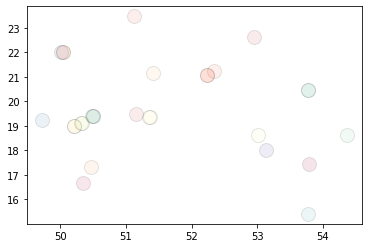

In [144]:
input_frame = users_frames_list[91].copy()
answer = answer_frame[answer_frame['id'] == input_frame.iloc[0]['user_id']][['lat','lon']].values
db = dbscan(input_frame)
print(db.labels_)
plot_dbscan(db,input_frame[["lat","lon"]].values, answer)